In [9]:
import pdb

from fastai.text import *

In [10]:
device = 'cuda:1'
torch.cuda.set_device(device)

print(f'fastai version: {__version__}')
print(f'Using cuda:{torch.cuda.current_device()} - {torch.cuda.get_device_name()}')

fastai version: 1.0.58
Using cuda:1 - GeForce GTX 1080 Ti


## Configuration

In [11]:
PATH = Path('data/translate')
PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH = untar_data(URLs.MT_ENG_FRA)
DATA_PATH.ls()

[PosixPath('/home/wgilliam/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/cc.fr.300.bin'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/models'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/cc.en.300.bin.gz'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/cc.fr.300.bin.gz'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/data_save.pkl')]

In [12]:
folder = 'giga-fren.release2.fixed'
en_folder = DATA_PATH/f'{folder}.en'
fr_folder = DATA_PATH/f'{folder}.fr'

## Prepare data

*NOTE: only need to run through the section 1x to build the .csv file*

In [13]:
# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')

# lines = ((re_eq.search(eq), re_fq.search(fq)) 
#           for eq, fq in zip(open(en_folder, encoding='utf-8'), open(fr_folder, encoding='utf-8')))

# qs = [ {'english_text': e.group(), 'french_text': f.group()} for e, f in lines if e and f ]

In [14]:
# qs[:5]

In [15]:
# df = pd.DataFrame(qs)
# df.head()

In [16]:
# df.to_csv(PATH/'english_french_translate.csv', index=False)

## Prepare data for training

In [17]:
np.random.seed(42)

In [18]:
df = pd.read_csv(PATH/'english_french_translate.csv')

print(len(df))
display(df.head())

52331


,english_text,french_text
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


**Why am I restricting my datasets to the mean length of French or corresponding English translation?**

Including the longer documents tend to require much more training, consume more memory, and don't necessarily work all that great for models such as we're building here.

In [19]:
en_max_len = np.percentile(df.english_text.str.len(), 95)
fr_max_len = np.percentile(df.french_text.str.len(), 95)
max_len = np.max([en_max_len, fr_max_len])

en_mean_len = np.mean(df.english_text.str.len())
fr_mean_len = np.mean(df.french_text.str.len())
max_mean = np.max([en_mean_len, fr_mean_len])

print(en_max_len, fr_max_len, max_len, en_mean_len, fr_mean_len, max_mean)

152.0 186.0 186.0 69.66941201200054 85.48424452045633 85.48424452045633


Keeping examples where both inputs and targets are < max 90th percentile

In [20]:
df = df.loc[(df.english_text.str.len() < max_len) & (df.french_text.str.len() < max_len)]
df.reset_index(inplace=True, drop=True)
df.head()

,english_text,french_text
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [21]:
train_df = df.sample(frac=0.8, random_state=42)
valid_df = df.iloc[~df.index.isin(train_df.index)]
len(train_df), len(valid_df)

(39671, 9918)

## Custom DataBlock API code

**Why am I creating my own collate function?**

Two reasons. First, I want to be able to pad both the inputs and targets (the default pad_collate function for TextList instances only takes are of the inputs). Second, I wanted to set things up so I could include my targets in training for "teacher forcing" as well as the actual, non-padded, lenghts of each document along with their corresponding masks for masking.

Writing your own collate_fn is a nice way to pass in whatever you need/want to your model's forward() function.

In [22]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_shifted_targets=True, shifted_idx:int=1,
                        include_lengths=False, include_masks=False,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)

    x_lens = [len(s[0]) for s in samples]
    x_max_len = max(x_lens)
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: x_res, y_res = x_res.flip(1), y_res.flip(1)
        
    x = [x_res]
    
    if (include_shifted_targets): 
        y = F.pad(y_res, (1, 0), value=shifted_idx)
        x += [y[:,:-1]]
        
    if (include_lengths): x += [torch.tensor(x_lens), torch.tensor(y_lens)]
    if (include_masks): x += [x_res != pad_idx, y_res != pad_idx]
    
    return x, y_res

**Why am I creating a custom DataBunch class?**


Because the default class for TextList doesn't allow me to override the collate_fn. Everything else pretty much comes right from the framework.

In [23]:
class Seq2SeqDataBunch(DataBunch):

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, 
               pad_idx=1, pad_first=False, shifted_idx=1, dl_tfms=None, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        
        """Function that transform the `datasets` in a `DataBunch` for classification. 
        Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, shifted_idx=shifted_idx, 
                             backwards=backwards)
        
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
            
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

Below is one of the reason I like the DataBlock API. I can inherit all the goodness form TextList while just overriding the DataBunch class. Very nice!

In [24]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList
    
    def reconstruct(self, t:Tensor):
        # this because the input, in addition to the data, can contain targets, lengths, and masks
        data_tensor = t[0] if isinstance(t, list) else t
        
        idx_min = (data_tensor != self.pad_idx).nonzero().min()
        idx_max = (data_tensor != self.pad_idx).nonzero().max()
        return Text(data_tensor[idx_min:idx_max+1], self.vocab.textify(data_tensor[idx_min:idx_max+1]))

## Build our DataBunch

In [25]:
bs = 64
val_bs = 128

tok_pre_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces]
tok_post_rules = [replace_all_caps, deal_caps]

In [26]:
en_tok = Tokenizer(lang='en', pre_rules=tok_pre_rules, post_rules=tok_post_rules)
fr_tok = Tokenizer(lang='fr', pre_rules=tok_pre_rules, post_rules=tok_post_rules)

In [27]:
en_procs = [TokenizeProcessor(tokenizer=en_tok, include_bos=False, include_eos=False), 
            NumericalizeProcessor(min_freq=1)]

fr_procs = [TokenizeProcessor(tokenizer=fr_tok,include_bos=False, include_eos=False), 
            NumericalizeProcessor(min_freq=1)]

In [28]:
en_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['english_text'], 
                                      processor=en_procs).process()

en_valid_il = Seq2SeqTextList.from_df(valid_df, path=PATH, cols=['english_text'], 
                                      processor=en_train_il.processor).process()

In [29]:
fr_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['french_text'], 
                                      processor=fr_procs).process()

fr_valid_il = Seq2SeqTextList.from_df(valid_df, path=PATH, cols=['french_text'], 
                                      processor=fr_train_il.processor).process()

Remember: A LabelList is a PyTorch Dataset

In [30]:
trn_ll = LabelList(fr_train_il, en_train_il)
val_ll = LabelList(fr_valid_il, en_valid_il)

lls = LabelLists(PATH, train=trn_ll, valid=val_ll)

In [31]:
len(lls.train.x.vocab.itos), len(lls.valid.x.vocab.itos), len(lls.train.y.vocab.itos), len(lls.valid.y.vocab.itos)

(22184, 22184, 15976, 15976)

In [32]:
lls.train.x[0]

Text xxmaj qu’ entend - on par barrières non tarifaires ?

In [33]:
lls.train.y[0]

Text xxmaj what are non - tariff barriers ?

In [34]:
print(list(lls.train.x.vocab.itos[:10]))
print(list(lls.train.y.vocab.itos[:10]))

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '?']
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '?']


### Creating a DataBunch via the API

In [35]:
# define the token idx for padding the right-shifted targets in the input (default=pad_idx=1)
shifted_idx = en_tok.special_cases.index(BOS)
data = lls.databunch(bs=bs, val_bs=val_bs, shifted_idx=shifted_idx)

In [36]:
b = next(iter(data.train_dl))

print('inputs:')
for i in range(len(b[0])): print(b[0][i].shape)
    
print('\ntargets:')
print(b[1].shape)

inputs:
torch.Size([64, 63])
torch.Size([64, 50])

targets:
torch.Size([64, 50])


In [37]:
data.show_batch()

text,target
xxmaj moins de 9 999 $ _ _ _ xxmaj de 10 000 $ à 19 999 $ _ _ _ xxmaj de 20 000 $ à 29 999 $ _ _ _ xxmaj de 30 000 $ à 39 999 $ _ _ _ 40 000 $ et plus _ _ _ xxmaj quel autre soutien financier vous est versé ?,"xxmaj what is your annual salary range : under $ 10,000 _ _ _ 10 - 20 _ _ _ 20 - 30 _ _ 30 - 40 _ _ _ 40 and over _ _ _ xxmaj what other kind of income support do you get ?"
xxmaj pourquoi cliquer sur cette page [ xxmaj site du xxmaj canada ] pour ensuite être amené à cette page - ci alors que j' ignorais que je pouvais aboutir à cette page à partir de la page du xxmaj site du xxmaj canada ?,xxmaj why click on that page [ xxmaj canada xxmaj site ] and then be brought to this page when i did n't even know i could come to this page from that page ?
"xxmaj et s’ il créait le pacte de la paix , un accord signé par des centaines , voire des milliers de jeunes s’ engageant , par simple fraternité , à détruire leur collection de jeux de guerre ?","xxmaj what if he created a xxmaj peace xxmaj pact , a promise signed by hundreds , even thousands , of young people united as brothers and sisters to destroy their collection of war games ?"
"xxmaj qu’ est - ce - qui fait que l’ xxmaj irlande , pour ce qui est de l’ économie , soit passée , pendant la même période , du peloton de queue au sommet de la catégorie ?",xxmaj what explains xxmaj ireland ’s rise from far behind to the top of the economic league in the same period ?
"xxmaj que puis - je faire pour soutenir la demande de visa de résident temporaire de mon ami , d' un membre de ma famille ou d' un homme / femme d' affaires ressource qui a été rejetée ?","xxmaj what can i do to support the application of my friend , relative or business contact who was refused a xxmaj temporary xxmaj resident xxmaj visa ?"


In [38]:
b[0][1]

tensor([[  2,   5,  11,  ...,  21,  23, 114],
        [  2,   5,  33,  ...,   1,   1,   1],
        [  2,   5,  39,  ...,   1,   1,   1],
        ...,
        [  2,   5,  40,  ...,   1,   1,   1],
        [  2,   5,  11,  ...,   1,   1,   1],
        [  2,   5,  11,  ...,   1,   1,   1]], device='cuda:1')

In [39]:
b[1]

tensor([[   5,   11,   14,  ...,   23,  114,    9],
        [   5,   33,   59,  ...,    1,    1,    1],
        [   5,   39, 2483,  ...,    1,    1,    1],
        ...,
        [   5,   40,   57,  ...,    1,    1,    1],
        [   5,   11,   84,  ...,    1,    1,    1],
        [   5,   11,   14,  ...,    1,    1,    1]], device='cuda:1')

In [40]:
data.save('data_1.pkl')
data = load_data(PATH, 'data_1.pkl', shifted_idx=shifted_idx)

### Creating DataBunch via DataLoaders

In [41]:
train_sampler = SortishSampler(lls.train.x, key=lambda t: len(lls.train[t][0].data), bs=bs//2)
valid_sampler = SortSampler(lls.valid.x, key=lambda t: len(lls.valid[t][0].data))

In [42]:
train_dl = DataLoader(lls.train, batch_size=bs, sampler=train_sampler, drop_last=True)
valid_dl = DataLoader(lls.valid, batch_size=val_bs, sampler=valid_sampler)

In [43]:
data = DataBunch(train_dl=train_dl, valid_dl=valid_dl, 
                 collate_fn=partial(seq2seq_pad_collate,shifted_idx=2))

### Creating DataBunch via API with filtering and dl transforms (optional)

In [44]:
df = pd.read_csv(PATH/'english_french_translate.csv')

Define batch sizes and tokenization/numericalization strategies

In [45]:
bs = 64
val_bs = 128

tok_pre_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces]
tok_post_rules = [replace_all_caps, deal_caps]

In [46]:
en_tok = Tokenizer(lang='en', pre_rules=tok_pre_rules, post_rules=tok_post_rules)
fr_tok = Tokenizer(lang='fr', pre_rules=tok_pre_rules, post_rules=tok_post_rules)

In [47]:
en_procs = [TokenizeProcessor(tokenizer=en_tok, include_bos=False, include_eos=False), 
            NumericalizeProcessor(min_freq=1)]

fr_procs = [TokenizeProcessor(tokenizer=fr_tok,include_bos=False, include_eos=False), 
            NumericalizeProcessor(min_freq=1)]

Build the datasets

In [48]:
src = (Seq2SeqTextList.from_df(df, path=PATH, cols='french_text', processor=fr_procs)
           .split_by_rand_pct()
           .label_from_df(cols='english_text', label_cls=TextList, processor=en_procs))

In [49]:
x_max_len = np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 95)
y_max_len = np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 95)
max_len = np.max([x_max_len, y_max_len])

print(x_max_len, y_max_len, max_len)

36.0 30.0 36.0


As before, we remove questions with more than `max_90` tokens using `filter_by_func`.  This is a more flexible approach as us to change the items included in the datasets defined in `src` *without* having to re-create them from scratch

In [50]:
src = src.filter_by_func(lambda x,y: len(x) > max_len or len(y) > max_len)
print(len(src.train) + len(src.valid))

49772


Build the databunch

In [51]:
shifted_idx = en_tok.special_cases.index(BOS)
data = src.databunch(bs=bs, val_bs=val_bs, shifted_idx=shifted_idx)

In [52]:
data.show_batch()

text,target
"xxmaj lorsque vous demandez une culture bactérienne d' un échantillon fécal et que vous ne faites aucune demande précise , prenez - vous pour acquis que le laboratoire testera automatiquement la présence des pathogènes suivants ?","xxmaj when you order a stool sample for bacterial culture , and you do not make any specific requests , is it your understanding that the lab will routinely test for the following pathogens ?"
xxmaj quels critères devraient régir la décision d’ administrer un traitement auquel elle n’ a pas consenti à une personne qui est incapable de prendre à cet égard une décision en toute connaissance de cause ?,xxmaj what criteria ought to govern the decision to impose treatment on a person who lacks capacity to make an understanding choice in the matter ?
xxmaj pourquoi devrions - nous mettre tous nos espoirs dans un vaccin quand on sait qu' il existe déjà des médicaments qui prolongent l' espérance de vie et permettent d' empêcher la progression du virus ?,xxmaj why should we pin all our hopes on a vaccine when we already have drugs that will extend people 's lives and can keep the virus in check ?
xxmaj pourquoi le pays le plus riche du monde devrait - il vivre au - dessus de ses moyens alors que le xxup fmi réprimande les pays les plus pauvres pour des transgressions moins importantes ?,xxmaj why should the richest country in the world live beyond its means while the xxup imf scolds poorer countries for smaller transgressions ?
"xxmaj quelle est par ailleurs la taille requise du logement en fonction du nombre de personnes accueillies , la durée ou la pérennité du titre de séjour , les prestations auxquelles ont droit les bénéficiaires ?",xxmaj what size of accommodation is required according to the number of persons taken in ; for how long are the residence permits valid and to what benefits are the persons concerned entitled ?


In [53]:
data.save('data_2.pkl')
data = load_data(PATH, 'data_2.pkl', shifted_idx=shifted_idx)

If we wanted to, we could add a dl transform as such to change the shifted padding index on the fly without having to rebuild our datasets/dataloaders

In [54]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=999)
    x.insert(1,y[:,:-1])
    return x, y[:,1:]

In [55]:
data = load_data(PATH, 'data_2.pkl', shifted_idx=shifted_idx)
data.add_tfm(shift_tfm)

In [56]:
b = next(iter(data.train_dl))

print('inputs:')
for i in range(len(b[0])): print(b[0][i].shape)
    
print('\ntargets:')
print(b[1].shape)

inputs:
torch.Size([64, 36])
torch.Size([64, 34])
torch.Size([64, 34])

targets:
torch.Size([64, 34])


In [57]:
b[0][1], b[1] #=> shifted outputs, target outputs

(tensor([[999,   5,  11,  ...,   1,   1,   1],
         [999,   5,  11,  ...,   1,   1,   1],
         [999,   5,  11,  ...,   1,   1,   1],
         ...,
         [999,   5,  11,  ...,   1,   1,   1],
         [999,   5,  22,  ...,   1,   1,   1],
         [999,   5,  41,  ...,   1,   1,   1]], device='cuda:1'),
 tensor([[   5,   11, 1983,  ...,    1,    1,    1],
         [   5,   11,  419,  ...,    1,    1,    1],
         [   5,   11,   89,  ...,    1,    1,    1],
         ...,
         [   5,   11,   15,  ...,    1,    1,    1],
         [   5,   22,   16,  ...,    1,    1,    1],
         [   5,   41,   34,  ...,    1,    1,    1]], device='cuda:1'))

## Transformer

### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:

In [58]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

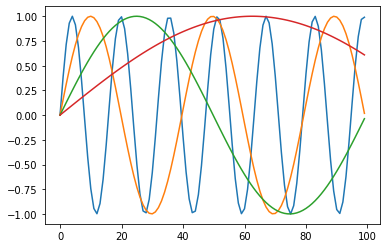

In [59]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [60]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Multi-head attention

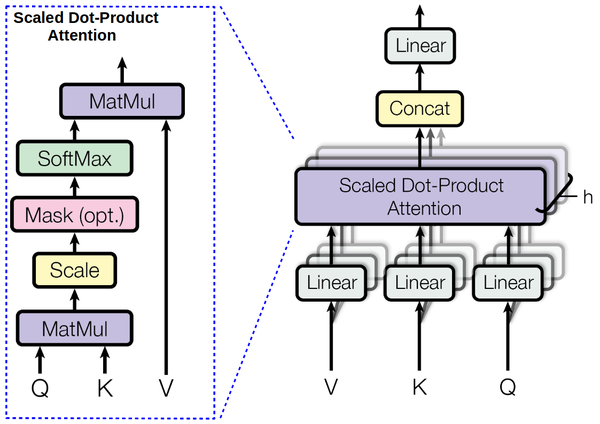

In [61]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_inp:int, d_head:int=None, 
                 resid_p:float=0., attn_p:float=0., bias:bool=True, scale:bool=True):
        super().__init__()
        
        d_head = ifnone(d_head, d_inp // d_inp)
        
        self.n_heads, self.d_head, self.scale = n_heads, d_head, scale
        
        self.q_wgt = nn.Linear(d_inp, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_inp, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_inp, n_heads * d_head, bias=bias)
        
        self.out = nn.Linear(n_heads * d_head, d_inp, bias=bias)
        
        self.drop_att,self.drop_res = nn.Dropout(attn_p), nn.Dropout(resid_p)
        
        self.ln = nn.LayerNorm(d_inp)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        weighted_v, attn_probs = self._apply_attention(q, k, v, mask=mask)
        out = self.drop_res(self.out(weighted_v))
        return self.ln(q + out)
        
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bsz, seq_len = q.size(0), q.size(1)
        
        wq, wk, wv = self.q_wgt(q), self.k_wgt(k), self.v_wgt(v)
        wq, wk, wv = map(lambda x:x.view(bsz, x.size(1), self.n_heads, self.d_head), (wq, wk, wv))
        wq, wk, wv = wq.permute(0, 2, 1, 3), wk.permute(0, 2, 3, 1), wv.permute(0, 2, 1, 3)
        
        attn_scores = torch.matmul(wq, wk)
        
        if self.scale: 
            attn_scores = attn_scores.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_scores = attn_scores.float().masked_fill(mask, -float('inf')).type_as(attn_scores)
            
        attn_probs = self.drop_att(F.softmax(attn_scores, dim=-1))
        
        weighted_v = torch.matmul(attn_probs, wv)
        return weighted_v.permute(0, 2, 1, 3).contiguous().contiguous().view(bsz, seq_len, -1), attn_probs
        
    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Permute and matmul is a little bit faster but this implementation is more readable
        bsz, seq_len = q.size(0), q.size(1)
        
        wq, wk, wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq, wk, wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq, wk, wv))
        
        attn_scores = torch.einsum('bind,bjnd->bijn', (wq, wk))
        
        if self.scale: 
            attn_scores = attn_scores.mul_(1/(self.d_head ** 0.5))
        if mask is not None: 
            attn_scores = attn_scores.float().masked_fill(mask, -float('inf')).type_as(attn_scores)
        
        attn_probs = self.drop_att(F.softmax(attn_scores, dim=2))
        
        weighted_v = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return weighted_v.contiguous().view(bsz, seq_len, -1), attn_probs

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [62]:
def get_padding_mask(inp, pad_idx:int=1):
    return None
    return (inp == pad_idx)[:,None,:,None]

In [63]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None].bool()
    return ((inp == pad_idx)[:, None, :, None].long() + 
            torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None,None] != 0)

In [64]:
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Feed forward

The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm.

In [65]:
def feed_forward(d_inp:int, d_ff:int, ff_p:float=0., double_drop:bool=True):
    layers = [nn.Linear(d_inp, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
        
    return SequentialEx(*layers, 
                        nn.Linear(d_ff, d_inp), 
                        nn.Dropout(ff_p), 
                        MergeLayer(), 
                        nn.LayerNorm(d_inp))

## Encoder and Decoder Blocks

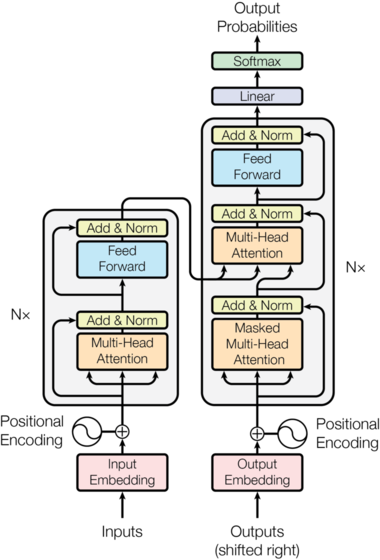

In [66]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    
    def __init__(self, n_heads:int, d_inp:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        
        super().__init__()
        
        self.mha = MultiHeadAttention(n_heads, d_inp, d_head, 
                                      resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        
        self.ff = feed_forward(d_inp, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None): 
        return self.ff(self.mha(x, x, x, mask=mask))

In [67]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."

    def __init__(self, n_heads:int, d_inp:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        
        super().__init__()
        
        self.mha1 = MultiHeadAttention(n_heads, d_inp, d_head, 
                                       resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        
        self.mha2 = MultiHeadAttention(n_heads, d_inp, d_head, 
                                       resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        
        self.ff = feed_forward(d_inp, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None): 
        out = self.mha1(x, x, x, mask_out)          # self-attention
        out = self.mha2(x, enc, enc, mask=mask_in)  # encoder/decoder attention
        return self.ff(out)

### The Transformer model

In [68]:
class Transformer(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, 
                 n_layers:int=6, n_heads:int=8, d_inp:int=256, d_head:int=32, d_inner:int=1024, 
                 inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, 
                 bias:bool=True, scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        
        super().__init__()
        
        self.enc_emb = TransformerEmbedding(inp_vsz, d_inp, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_inp, 0.)
        
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_inp, d_head, d_inner, resid_p, attn_p, ff_p, 
                                                   bias, scale, double_drop) for _ in range(n_layers)])
        
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_inp, d_head, d_inner, 
                                                   resid_p, attn_p, ff_p, 
                                                   bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_inp, out_vsz)
        
        self.out.weight = self.dec_emb.embed.weight
        
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_src  = get_padding_mask(inp, self.pad_idx)
        mask_trg = get_output_mask (out, self.pad_idx)
        
        src, trg = self.enc_emb(inp), self.dec_emb(out)
        
        for enc_block in self.encoder: src = enc_block(src, mask_src)
        for dec_block in self.decoder: trg = dec_block(trg, src, mask_src, mask_trg)
        return self.out(trg)

In [69]:
class Transformer2(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, 
                 n_layers:int=6, n_heads:int=8, d_inp:int=256, d_head:int=32, d_inner:int=1024, 
                 inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, 
                 bias:bool=True, scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        
        super().__init__()
        
        self.enc_emb = TransformerEmbedding(inp_vsz, d_inp, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_inp, 0.)
        
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_inp, d_head, d_inner, resid_p, attn_p, ff_p, 
                                                   bias, scale, double_drop) for _ in range(n_layers)])
        
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_inp, d_head, d_inner, 
                                                   resid_p, attn_p, ff_p, 
                                                   bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_inp, out_vsz)
        
        self.out.weight = self.dec_emb.embed.weight
        
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_src  = get_padding_mask(inp, self.pad_idx)
        mask_trg = get_output_mask (out, self.pad_idx)
        
        src, trg = self.enc_emb(inp), self.dec_emb(out)
        
        enc_outputs = []
        for idx, enc_block in enumerate(self.encoder): 
            src = enc_block(src, mask_src)
            enc_outputs.append(src)
            
        for idx, dec_block in enumerate(self.decoder): 
            trg = dec_block(trg, enc_outputs[idx], mask_src, mask_trg)
            
        return self.out(trg)

## Bleu metric 

See dedicated notebook

In [70]:
class NGram():
    def __init__(self, ngram, max_n=5000): 
        self.ngram, self.max_n = ngram, max_n
        
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    
    def __hash__(self): 
        return int(sum([ o * self.max_n**i for i, o in enumerate(self.ngram) ]))

In [71]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [ NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1) ]

In [72]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    
    return sum([ min(c, targ_cnt[g]) for g,c in pred_cnt.items() ]), len(pred_grams)

In [73]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i] += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [ c/t for c, t in zip(self.corrects,self.counts) ]
        
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        
        bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
        
        return add_metrics(last_metrics, bleu)

## Training

In [74]:
shifted_idx = en_tok.special_cases.index(BOS)
data = load_data(PATH, 'data_2.pkl', bs=128, val_bs=256, shifted_idx=shifted_idx)

In [75]:
try: learn.destroy(); learn.purge(); learn = None; gc.collect(); torch.cuda.empty_cache()
except: pass

In [76]:
p_mult= 1

model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), 
                    n_layers=6, d_inp=512, n_heads=8, d_head=64, d_inner=2048,
                    inp_p=0.1*p_mult, resid_p=0.1*p_mult, attn_p=0.1*p_mult, ff_p=0.1*p_mult)

In [77]:
learn = Learner(data, 
                model, 
                metrics=[ accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos)) ], 
                loss_func = CrossEntropyFlat())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


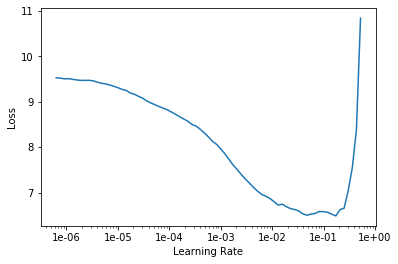

In [78]:
learn.lr_find()
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

# final acc/bleu Transformer  = 0.777987	0.650103
# final acc/bleu Transformer2 = 0.778919	0.655187

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.451249,2.341283,0.650746,0.548448,01:18
1,2.216482,2.086355,0.677285,0.552907,01:19
2,1.744299,1.791988,0.717938,0.586367,01:20
3,1.437060,1.545233,0.747074,0.614853,01:19
4,1.225073,1.425202,0.763856,0.632004,01:20
5,0.924580,1.396154,0.773153,0.643565,01:20
6,0.796753,1.402485,0.777286,0.648901,01:20
7,0.698285,1.412895,0.777405,0.649557,01:20


In [72]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            
            for x,y,z in zip(xb[0], xb[1], out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
                
    return inputs, targets, outputs

In [73]:
inputs, targets, outputs = get_predictions(learn)

In [74]:
inputs[10],targets[10],outputs[10]

(Text xxmaj pourquoi le xxmaj conseil de l’ xxmaj europe organise - t - il une grande campagne contre la violence à l’ égard des femmes , y compris la violence domestique , et pourquoi aujourd’hui ?,
 Text xxbos xxmaj why is the xxmaj council of xxmaj europe carrying out an entire campaign against domestic violence – and why now ?,
 Text xxmaj why is the xxmaj council of xxmaj europe revise out an campaign campaign against women violence against – women is ,)

In [75]:
inputs[700],targets[700],outputs[700]

(Text xxmaj quelles préoccupations pour la santé les chercheurs médicaux soulèvent - ils à propos des matières plastiques pouvant se « xxunk » dans l’ eau des bouteilles ?,
 Text xxbos xxmaj what kind of health questions do medical researchers raise about xxunk " xxunk " into the water in water xxunk ?,
 Text xxmaj what health of health concerns to the researchers from the the a hazardous a bumped the " supply the supply a)

In [76]:
inputs[701],targets[701],outputs[701]

(Text xxmaj quelle autre proposition suggèreriez - vous afin d’ élaborer et de réorganiser les approches au problème des xxup lmr dans le processus du xxmaj renouveau législatif ?,
 Text xxbos xxmaj what other proposals would you suggest to revamp approaches to the xxup mrl issue in the legislation renewal process ?,
 Text xxmaj what other proposal would you suggest to develop approaches to the xxup ea issue of the xxmaj legislation process ?)

In [77]:
inputs[2500],targets[2500],outputs[2500]

(Text xxmaj quelles sont les exigences et les étapes à franchir en vue d' obtenir un enregistrement de xxup tci ?,
 Text xxbos xxmaj what are the requirements and steps for obtaining an integrated circuit topography registration ?,
 Text xxmaj what are the requirements and steps for xxmaj a xxup xxmaj topography ? ?)

In [78]:
inputs[4002],targets[4002],outputs[4002]

(Text xxmaj quelle serait l' incidence d' une telle obligation sur les fournisseurs de services de programmation ?,
 Text xxbos xxmaj what effect , if any , would such a requirement have on programming service providers ?,
 Text xxmaj what would would if any , does have service service of on programming programming providers ?)

## Training with Label smoothing

They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [79]:
try: learn.destroy(); learn.purge(); learn = None; gc.collect(); torch.cuda.empty_cache()
except: pass

this Learner object self-destroyed - it still exists, but no longer usable
this object has been destroyed


In [80]:
p_mult= 1

model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), 
                    n_layers=6, d_inp=512, n_heads=8, d_head=64, d_inner=2048,
                    inp_p=0.1*p_mult, resid_p=0.1*p_mult, attn_p=0.1*p_mult, ff_p=0.1*p_mult)

In [81]:
learn = Learner(data, 
                model, 
                metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [82]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.444345,3.331615,0.653676,0.547837,01:20
1,3.179899,3.144272,0.671906,0.553816,01:21
2,2.976780,2.935330,0.705135,0.572160,01:20
3,2.670957,2.692283,0.741964,0.607721,01:19
4,2.469953,2.570217,0.760099,0.626703,01:19
5,2.240818,2.533178,0.768883,0.636445,01:19
6,2.055273,2.520301,0.774898,0.645486,01:20
7,1.996721,2.531414,0.775542,0.646462,01:20


In [83]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

# final acc/bleu Transformer  = 0.792145	0.676361
# final acc/bleu Transformer2 = 0.792084	0.679445

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.062765,2.542817,0.771094,0.641162,01:19
1,2.090187,2.544931,0.769975,0.639861,01:20
2,2.043633,2.546366,0.772180,0.643641,01:18
3,1.917475,2.533861,0.777781,0.652558,01:20
4,1.778482,2.548270,0.784087,0.660600,01:20
5,1.636508,2.570303,0.789192,0.670855,01:21
6,1.552929,2.590939,0.791898,0.676279,01:19
7,1.501993,2.598413,0.792549,0.677013,01:20


In [84]:
print("Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?")

print("What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?")

print("Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?")

print("What are the long the long - term policies implications of this global scientific ? ?")

Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?
What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?
Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?
What are the long the long - term policies implications of this global scientific ? ?


In [85]:
inputs, targets, outputs = get_predictions(learn)

In [86]:
inputs[10],targets[10],outputs[10]

(Text xxmaj pourquoi le xxmaj conseil de l’ xxmaj europe organise - t - il une grande campagne contre la violence à l’ égard des femmes , y compris la violence domestique , et pourquoi aujourd’hui ?,
 Text xxbos xxmaj why is the xxmaj council of xxmaj europe carrying out an entire campaign against domestic violence – and why now ?,
 Text xxmaj why is the xxmaj council of xxmaj europe carrying out an entire campaign against violence violence , and why now ?)

In [87]:
inputs[700],targets[700],outputs[700]

(Text xxmaj quelles préoccupations pour la santé les chercheurs médicaux soulèvent - ils à propos des matières plastiques pouvant se « xxunk » dans l’ eau des bouteilles ?,
 Text xxbos xxmaj what kind of health questions do medical researchers raise about xxunk " xxunk " into the water in water xxunk ?,
 Text xxmaj what concerns of health researchers using to researchers using xxmaj the the green for restaurants " " ? the ? ?)

In [88]:
inputs[701],targets[701],outputs[701]

(Text xxmaj quelle autre proposition suggèreriez - vous afin d’ élaborer et de réorganiser les approches au problème des xxup lmr dans le processus du xxmaj renouveau législatif ?,
 Text xxbos xxmaj what other proposals would you suggest to revamp approaches to the xxup mrl issue in the legislation renewal process ?,
 Text xxmaj what other proposals would you suggest to the approaches to the xxup mrl issue in the legislation renewal process ?)

In [89]:
inputs[2500],targets[2500],outputs[2500]

(Text xxmaj quelles sont les exigences et les étapes à franchir en vue d' obtenir un enregistrement de xxup tci ?,
 Text xxbos xxmaj what are the requirements and steps for obtaining an integrated circuit topography registration ?,
 Text xxmaj what are the requirements and steps to obtaining a xxup xxup topography registration ?)

In [90]:
inputs[4002],targets[4002],outputs[4002]

(Text xxmaj quelle serait l' incidence d' une telle obligation sur les fournisseurs de services de programmation ?,
 Text xxbos xxmaj what effect , if any , would such a requirement have on programming service providers ?,
 Text xxmaj what would would if any , do such a responsibility of on programming ? providers ?)

In [80]:
en_tok.special_cases.index(BOS)

2

In [88]:
def beam_search(learn, ds_type=DatasetType.Valid, n_words:int=20, 
                no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                sep:str=' '):
    
    "Return the `n_words` that come after `text` using beam search."
    
    learn.model.eval()
    
    bos_idx = en_tok.special_cases.index(BOS)
    
    inputs, targets, outputs = [], [], []
    
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):

            nodes = None
            bsz, inp_sl = xb[0].size()
            dec_inp = (xb[0].new_zeros(bsz) + bos_idx).unsqueeze(1)
            nodes = dec_inp.clone()
            scores = dec_inp.new_zeros(1).float()
            
            for k in progress_bar(range(n_words), leave=False):
                
                out = F.log_softmax(learn.model(xb[0], dec_inp), dim=-1) #=> (bsz, :k, vocab_sz)
                
                if no_unk: out[:,:,learn.data.y.vocab.stoi[UNK]] = -float('Inf')
                    
                values, indices = out.topk(top_k, dim=-1)     #=> (256, 1, 10) | (256, 1, 10)
                scores = (-values + scores[:,None]).view(-1)  #=> (2560)
            
                indices_idx = torch.arange(0, bsz)[:,None].expand(bsz, top_k).contiguous().view(-1) #=> (2560)
                
                sort_idx = scores.argsort()[:beam_sz] #=> (1000)
                scores = scores[sort_idx]             #=> (1000)
                
                pdb.set_trace()
                nodes = torch.cat([nodes[:,None].expand(bsz, top_k, nodes.size(1)),
                                   indices[:,:,:,None].expand(bsz, top_k, 1),], dim=2)
                
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]
                
                learn.model[0].select_hidden(indices_idx[sort_idx])
                xb = nodes[:,-1][:,None]
                
            if temperature != 1.: scores.div_(temperature)
            
            node_idx = torch.multinomial(torch.exp(-scores), 1).item()
            
            for x,y,z in zip(xb[0], xb[1], out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
                
    return inputs, targets, outputs

In [89]:
inputs, targets, outputs = beam_search(learn)

BdbQuit: 

In [ ]:
# 17360 = number of target tokens